In [3]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.multiplex_utils import multiplex_preprocess

In [4]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [5]:
#train_dict = np.load(NPZ_DIR + '20200930_multiplex_train_split.npz', allow_pickle=True)['0.005'].item()

In [44]:
# train_dict = np.load(NPZ_DIR + '20200930_multiplex_train_single_batch_no_crop.npz')
# X_train, y_train = train_dict['X'], train_dict['y']
# print(X_train.shape, y_train.shape)

(32, 256, 256, 2) (32, 256, 256, 1)


In [6]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200930_multiplex_"

train_dict = np.load(NPZ_DIR + npz_name + "train_512x512.npz")
val_dict = np.load(NPZ_DIR + npz_name + "val_256x256.npz")
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

In [7]:
X_train = multiplex_preprocess(X_train)
X_val = multiplex_preprocess(X_val)

In [8]:
print(X_train.shape, X_val.shape)

(12, 512, 512, 2) (3107, 256, 256, 2)


In [9]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=2,
    num_semantic_classes=[1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W1001 20:56:32.431130 140562698766144 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + 'deep_watershed'

n_epoch = 33  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 0  # throw out images with fewer than this many objects
seed=0
model_name

'20200930_multiplex_deep_watershed_single_batch_198_epochs'

In [19]:
from deepcell import image_generators
from deepcell.utils import train_utils


#use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256),
    float_dtype='float16',
    int_dtype='int16')

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    float_dtype='float16',
    int_dtype='int16')    

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
#     transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
#     transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
#                       'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
#     transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
#     transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
#                       'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    transforms=['inner-distance', 'pixelwise'],
    transforms_kwargs={'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

W1001 21:01:24.170870 140562698766144 semantic.py:111] X data dtype is float32: this will increase memory use during preprocessing. Consider using a smaller dtype


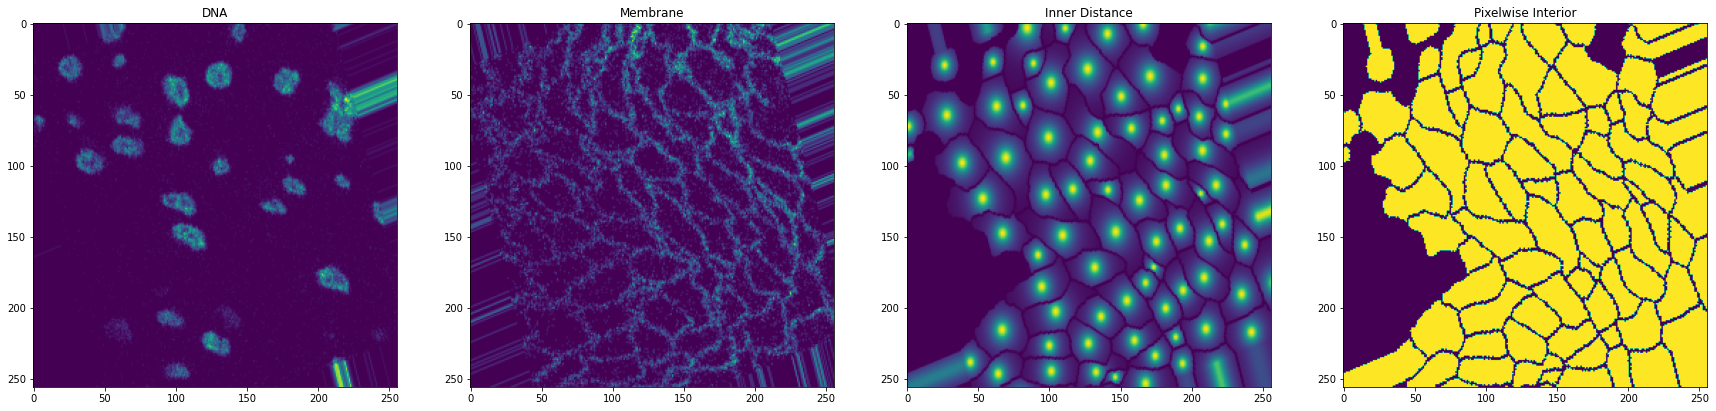

In [22]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
# inner_distance = outputs[0]
# outer_distance = outputs[1]
# fgbg = outputs[2]
# pixelwise = outputs[3]

inner_distance = outputs[0]
pixelwise = outputs[1]


fig, axes = plt.subplots(1, 4, figsize=(30, 30))

axes[0].imshow(img[:, :, 0])
axes[0].set_title('DNA')

axes[1].imshow(img[:, :, 1])
axes[1].set_title('Membrane')

axes[2].imshow(inner_distance[0, ..., 0].astype('float32'))
axes[2].set_title('Inner Distance')

# axes[3].imshow(outer_distance[0, ..., 0].astype('float32'))
# axes[3].set_title('Outer Distance')

axes[3].imshow(pixelwise[0, ..., 1].astype('float32'))
axes[3].set_title('Pixelwise Interior')

plt.show()

In [23]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [24]:
new_model.compile(loss=loss, optimizer=optimizer)

In [25]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    #tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    #steps_per_epoch=train_data.y.shape[0] // batch_size,
    steps_per_epoch=319,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/198


W1001 21:01:50.547498 140562698766144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


49/50 [============================>.] - ETA: 0s - loss: 0.0849 - semantic_0_loss: 0.0756 - semantic_1_loss: 0.0093
Epoch 00001: val_loss improved from inf to 0.16247, saving model to /data/models/20200619_production_updates/20200930_multiplex_deep_watershed_single_batch_198_epochs.h5
50/50 [==============================] - 94s 2s/step - loss: 0.0838 - semantic_0_loss: 0.0746 - semantic_1_loss: 0.0092 - val_loss: 0.1625 - val_semantic_0_loss: 0.0564 - val_semantic_1_loss: 0.1061
Epoch 2/198
49/50 [============================>.] - ETA: 0s - loss: 0.0330 - semantic_0_loss: 0.0255 - semantic_1_loss: 0.0075
Epoch 00002: val_loss improved from 0.16247 to 0.16129, saving model to /data/models/20200619_production_updates/20200930_multiplex_deep_watershed_single_batch_198_epochs.h5
50/50 [==============================] - 31s 629ms/step - loss: 0.0330 - semantic_0_loss: 0.0255 - semantic_1_loss: 0.0075 - val_loss: 0.1613 - val_semantic_0_loss: 0.0543 - val_semantic_1_loss: 0.1070
Epoch 3/198

Epoch 19/198
49/50 [============================>.] - ETA: 0s - loss: 0.0183 - semantic_0_loss: 0.0133 - semantic_1_loss: 0.0051
Epoch 00019: val_loss improved from 0.02210 to 0.02023, saving model to /data/models/20200619_production_updates/20200930_multiplex_deep_watershed_single_batch_198_epochs.h5
50/50 [==============================] - 31s 630ms/step - loss: 0.0183 - semantic_0_loss: 0.0132 - semantic_1_loss: 0.0051 - val_loss: 0.0202 - val_semantic_0_loss: 0.0145 - val_semantic_1_loss: 0.0057
Epoch 20/198
49/50 [============================>.] - ETA: 0s - loss: 0.0178 - semantic_0_loss: 0.0128 - semantic_1_loss: 0.0050
Epoch 00020: val_loss improved from 0.02023 to 0.01941, saving model to /data/models/20200619_production_updates/20200930_multiplex_deep_watershed_single_batch_198_epochs.h5
50/50 [==============================] - 32s 632ms/step - loss: 0.0177 - semantic_0_loss: 0.0127 - semantic_1_loss: 0.0050 - val_loss: 0.0194 - val_semantic_0_loss: 0.0142 - val_semantic_1_los

49/50 [============================>.] - ETA: 0s - loss: 0.0144 - semantic_0_loss: 0.0102 - semantic_1_loss: 0.0042
Epoch 00056: val_loss did not improve from 0.01626
50/50 [==============================] - 28s 563ms/step - loss: 0.0144 - semantic_0_loss: 0.0102 - semantic_1_loss: 0.0042 - val_loss: 0.0166 - val_semantic_0_loss: 0.0116 - val_semantic_1_loss: 0.0049
Epoch 57/198
49/50 [============================>.] - ETA: 0s - loss: 0.0137 - semantic_0_loss: 0.0095 - semantic_1_loss: 0.0042
Epoch 00057: val_loss did not improve from 0.01626
50/50 [==============================] - 28s 567ms/step - loss: 0.0136 - semantic_0_loss: 0.0095 - semantic_1_loss: 0.0042 - val_loss: 0.0164 - val_semantic_0_loss: 0.0116 - val_semantic_1_loss: 0.0048
Epoch 58/198
49/50 [============================>.] - ETA: 0s - loss: 0.0141 - semantic_0_loss: 0.0099 - semantic_1_loss: 0.0042
Epoch 00058: val_loss did not improve from 0.01626
50/50 [==============================] - 28s 568ms/step - loss: 0.014

KeyboardInterrupt: 

In [16]:
new_model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [18]:
test_dict = np.load(NPZ_DIR + npz_name + 'test_256x256.npz')
X_test = test_dict['X']
y_test = test_dict['y']
X_test = multiplex_preprocess(X_test)

In [35]:
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation(use_pretrained_weights=False)

In [19]:
inner_distance, pixelwise = new_model.predict(X_test)

In [20]:
small_idx = np.random.choice(range(X_test.shape[0]), 200, replace=False)

In [21]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance': inner_distance[small_idx],
                                     'pixelwise-interior': pixelwise[small_idx, :, :, 1:2]}, 
                                     maxima_threshold=0.1, maxima_model_smooth=0,
                                    interior_threshold=0.3,
                                    radius=3,
                                    small_objects_threshold=10,
                                     fill_holes_threshold=10)

In [22]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [23]:
RGB_data = make_color_overlay(X_test[small_idx, :, :, :])
true_overlay = make_outline_overlay(RGB_data, y_test[small_idx, :, :, 0])

In [24]:
predicted_overlay = make_outline_overlay(RGB_data, labeled_images[..., 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


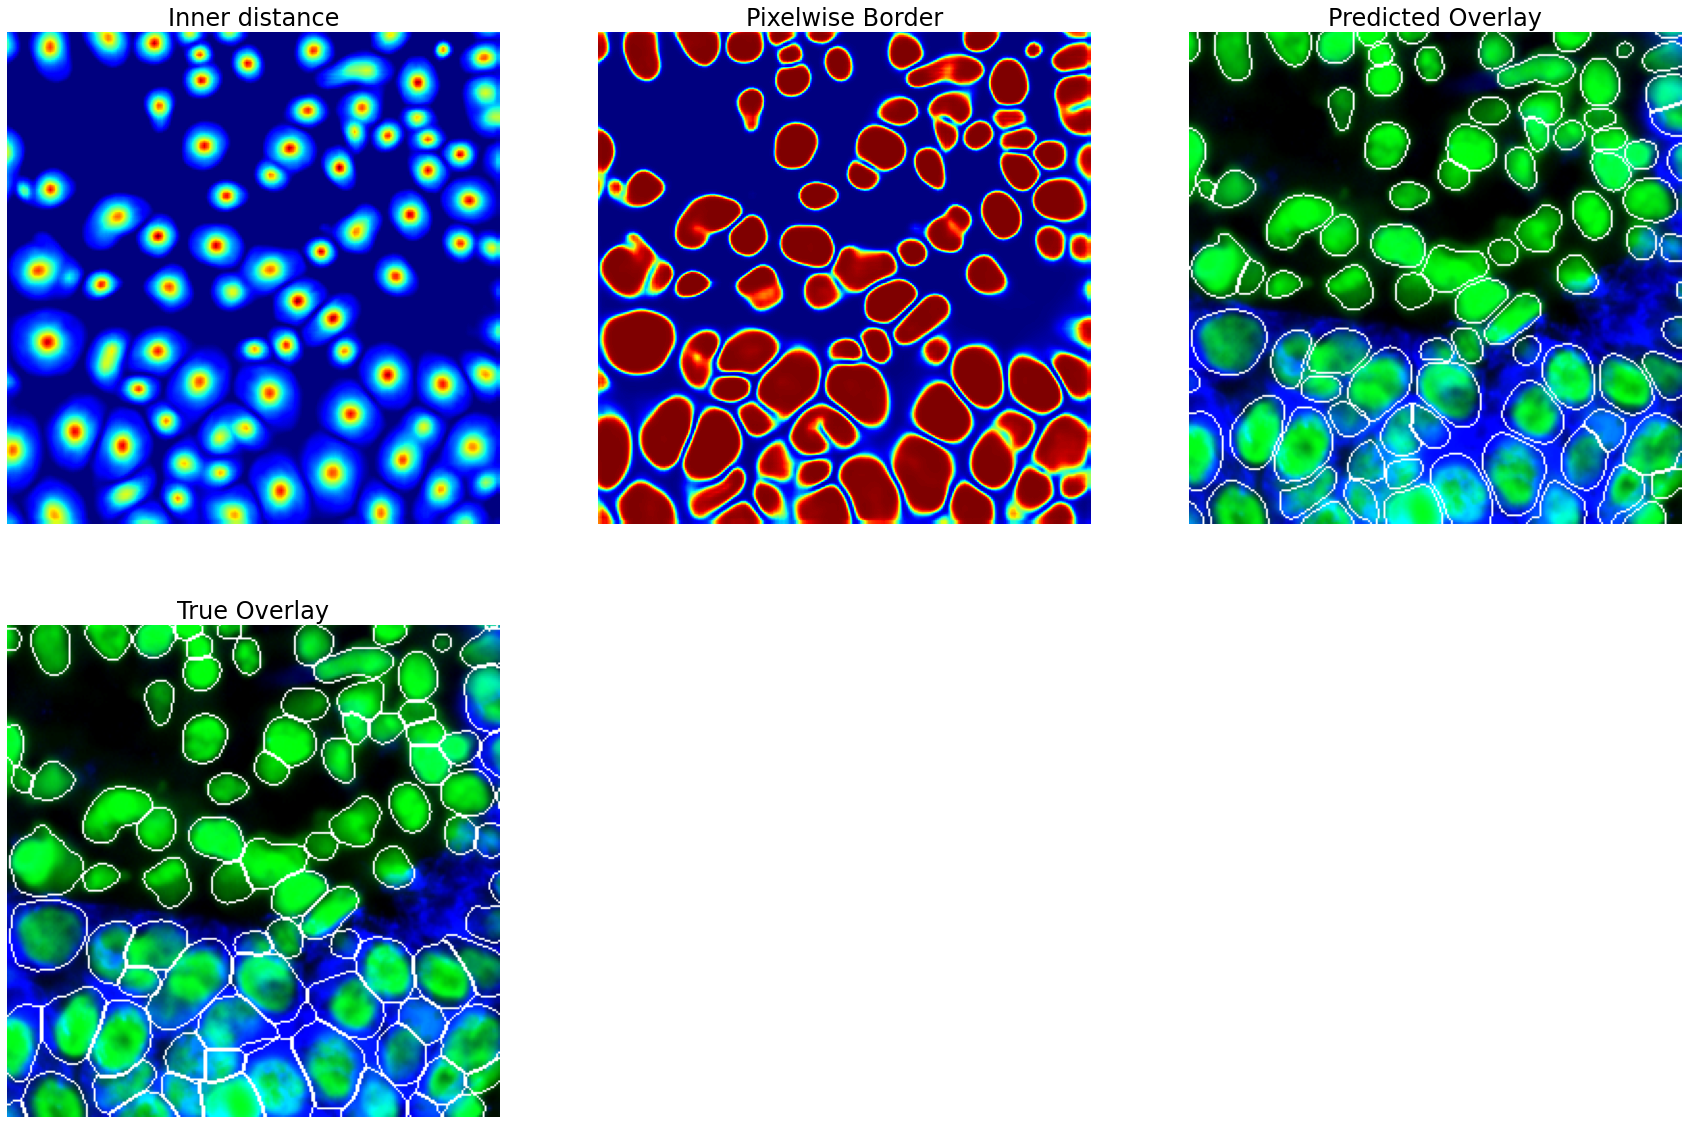

In [31]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 145
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(inner_distance[small_idx[index],...,0], cmap='jet')
axes[1].imshow(pixelwise[small_idx[index],...,1], cmap='jet')
axes[2].imshow(predicted_overlay[index, ...], cmap=cmap)
axes[3].imshow(true_overlay[index, ...], cmap=cmap)

axes[0].set_title('Inner distance', fontsize=24)
axes[1].set_title('Pixelwise Border', fontsize=24)
axes[2].set_title('Predicted Overlay', fontsize=24)
axes[3].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [39]:
len(np.unique(true[true == 5]))

0